In [1]:
# Import general util libraries

import torch
from torch.utils import data
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn') 
matplotlib.rcParams['font.family'] = 'serif'  
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Avoid iOS bug with pyplot. 


# Data loading
from utils.dlc_practical_prologue import generate_pair_sets



# Import models
from models.LeNet import lenet
from models.LinearReluNet import linear_relu_net
from models.SimpleConvNet import simple_conv_net
from models.ResNet import residual_net


from collections import OrderedDict


# Import plot utils
from utils.plot_utils import *
from utils.ml_utils import *
from utils.data_utils import *
from utils.metrics import accuracy




In [66]:
N = 1000  # Number of pairs
NN_ARGS = {"input_size": 14 * 14, "num_classes": 10}
DROP = {"d1" : 0, "d2" : 0}
DROP_RES = {"d" : 0.15}
BATCH_SIZE = 10
NUM_EPOCHS = 25
NUM_ITER = 10
MODELS = {
    "SimpleConvNet" : {"args" : DROP , "f" :simple_conv_net, "flatten": False, "name":"Simple Conv" },
    "LinearRelu": {"args": NN_ARGS, "f": linear_relu_net, "flatten": True, "name":"Linear ReLu"},
    "LeNet": {"args": DROP, "f": lenet, "flatten": False, "name":"LeNet"},
    "ResNet": {"args": DROP_RES, "f": residual_net, "flatten": False, "name":"Residual Net"},
}

In [3]:
def full_train_test(model_info, num_iter, num_epochs, data_size, batch_size, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Copy all model parameters to the GPU
    
    args = model_info.get('args')
    if args is None:
        model = model_info.get('f')()
    else:
        model = model_info.get('f')(**args)

    model = model.to(device)
    
    all_train_losses = [] 
    all_test_losses = []
    
    all_test_accuracies = []
    
    for it in range(1, num_iter + 1):
        print("Iteration %d" % it)
        
        # Generate a new dataset
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(data_size)
        
        # Build Keras loaders for train and test datasets batches.
        tr_loader, te_loader = build_train_loaders(train_input, train_classes, test_input, test_classes, batch_size)
        
        tr_losses, te_losses = train_model(model, device, num_epochs, tr_loader, te_loader, model_info.get('flatten'), verbose)
        
       # plot_train_test(tr_losses, te_losses, model_info.get('name'))
    
        if verbose:
            print("Final train loss: %.4f" % tr_losses[-1])
            print("Final test loss: %.4f" % te_losses[-1])
    
        all_train_losses.append(tr_losses)
        all_test_losses.append(te_losses)
        
        _,_,_, acc_input, acc_target, _ = generate_pair_sets(data_size)
        acc_loader = build_test_loader(acc_input, acc_target, batch_size)
        
        acc = accuracy(model, acc_loader, model_info.get('flatten'))
        if verbose:
            print("Test accuracy: %.4f" % acc)
        all_test_accuracies.append(acc)
    
    
    plot_losses(all_train_losses, all_test_losses, model_info.get('name'))
    
    plot_accuracy(all_test_accuracies, model_info.get('name'))
    
    
    return all_train_losses, all_test_losses, all_test_accuracies
        
       
            


In [52]:
class WeightSharingNet(nn.Module):  
    def __init__(self, num_classes=10):
        super(WeightSharingNet, self).__init__()

        self.cnn_layers = nn.Sequential(
            OrderedDict(
                [
                    ("C1", nn.Conv2d(1, 20, kernel_size=(2, 2))),
                    ("Relu1", nn.ReLU())
                ]
            )
        )

        self.linear_layers = nn.Sequential(
            OrderedDict(
                [
                    ("F1", nn.Linear(3380, 64)),
                    ("Relu4", nn.ReLU()),
                    ("F2", nn.Linear(64, num_classes))
                ]
            )
        )

    # Defining the forward pass    
    def forward(self, x):
        out = self.cnn_layers(x)
        out = out.view(x.shape[0], -1)
        out = self.linear_layers(out)
        return out
    
def weight_sharing_net(**kwargs):
    model = WeightSharingNet(**kwargs)
    return model

In [53]:
weight_sharing_model = {"args": None, "f": weight_sharing_net, "flatten": False, "name":"NN with weight sharing"}

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


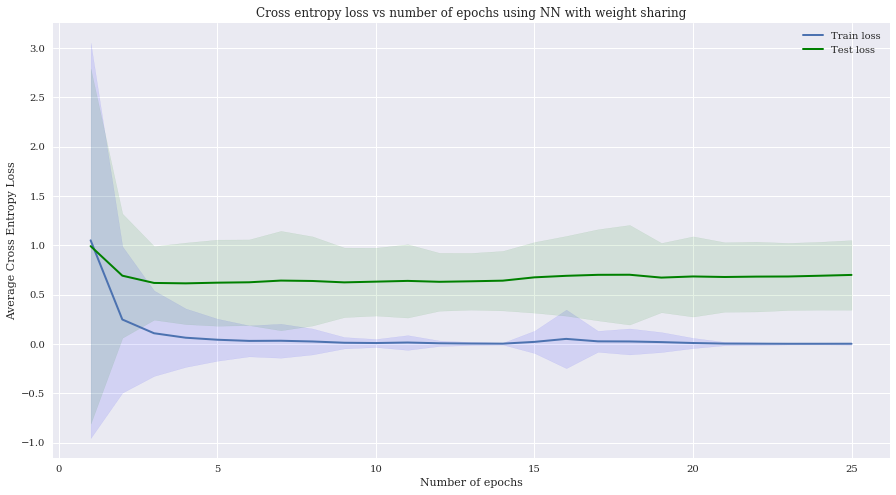

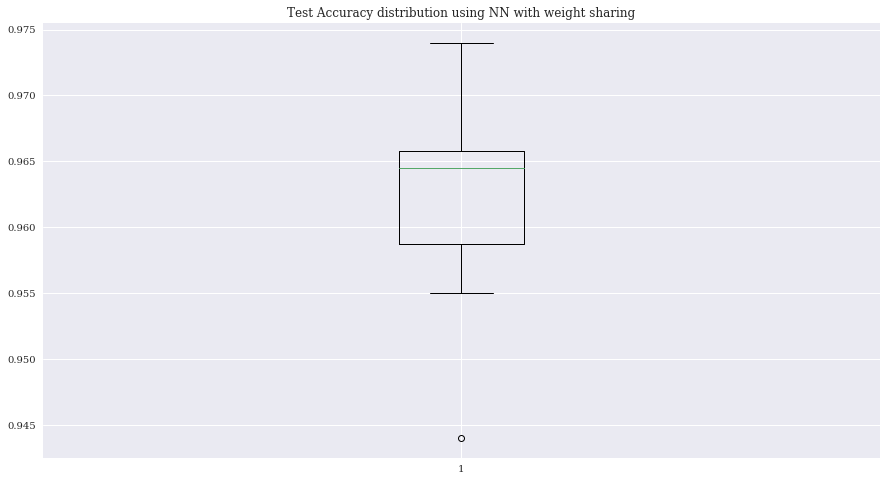

Weight sharing execution time: 207.55978083610535


In [71]:
import time

start = time.time()
ws_train_losses, ws_test_losses, ws_test_accuracy = full_train_test(weight_sharing_model, NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE) 
end = time.time()
print("Weight sharing execution time:", end - start)

In [72]:
class NoWeightSharingNet(nn.Module):   
    def __init__(self, input_size=14*14, num_classes=10):
        super(NoWeightSharingNet, self).__init__()
        
        
        self.net = nn.Sequential(
            OrderedDict(
                [
                    ("linear_1", nn.Linear(input_size, input_size*20)),
                    ("Relu1", nn.ReLU()),
                    ("linear_2", nn.Linear(input_size*20, 64)),
                    ("Relu2", nn.ReLU()),
                    ("linear_3", nn.Linear(64, num_classes)),

                ]
            )
        )


    # Defining the forward pass    
    def forward(self, x):
        out = self.net(x)
        return out
    
def no_weight_sharing_net(**kwargs):
    model = NoWeightSharingNet(**kwargs)
    return model



In [73]:
no_weight_sharing_model = {"args": None, "f": no_weight_sharing_net, "flatten": True, "name":"NN without weight sharing"}

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


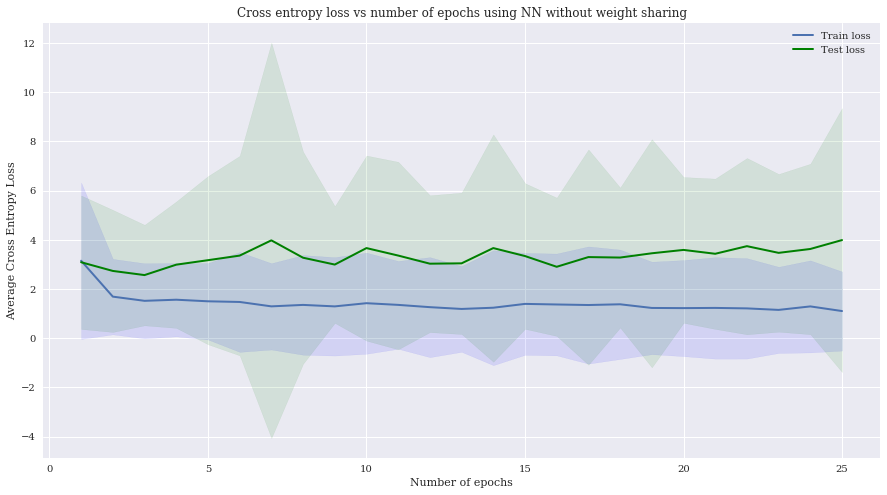

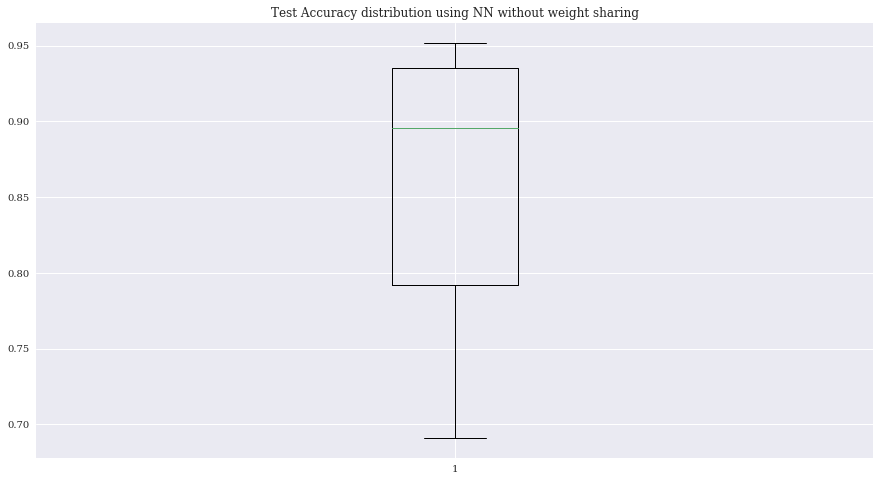

No Weight sharing execution time: 634.793445110321


In [75]:
start = time.time()
nws_train_losses, nws_test_losses, nws_test_accuracy = full_train_test(no_weight_sharing_model, NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE) 
end = time.time()
print("No Weight sharing execution time:", end - start)

In [76]:

# Build train and test losses during training with confidence interval 
def compare_weight_sharing(ws_losses, nws_losses):

    ws_mean, ws_upper, ws_lower = build_conf_interval(ws_losses)
    nws_mean, nws_upper, nws_lower = build_conf_interval(nws_losses)
    x = range(1, len(ws_mean) + 1)
    
    plt.figure(figsize=(15, 8))
    plt.plot(x, ws_mean, linewidth=2, label='Weight sharing loss') #mean curve.
    plt.plot(x, nws_mean, linewidth=2, color='g', label='No Weight sharing loss')
    plt.fill_between(x, ws_lower, ws_upper, color='b', alpha=.5)
    plt.fill_between(x, nws_lower, nws_upper, color='g', alpha=.1)
    
    plt.legend()
    plt.ylabel('Average Cross Entropy Loss')
    plt.xlabel("Number of epochs")
    plt.title('Cross entropy loss vs number of epochs using - Weight sharing')
    plt.show()

    

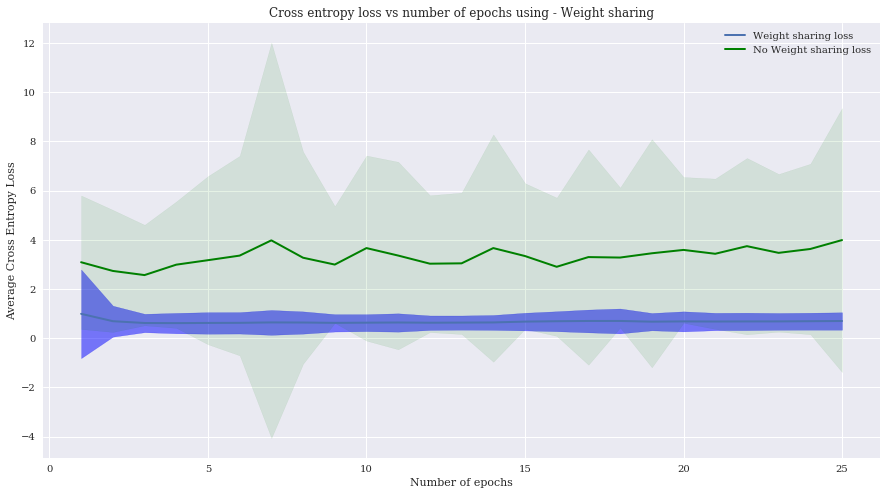

In [77]:
compare_weight_sharing(ws_test_losses, nws_test_losses)